In [2]:
# Import required libraries  
import os  
import json  
import requests
import http.client, urllib.parse
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv  
from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential

from IPython.display import Image, display

from sklearn.metrics.pairwise import cosine_similarity
  
load_dotenv()  
service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")  
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
api_version = os.getenv("AZURE_SEARCH_API_VERSION")
key = os.getenv("AZURE_SEARCH_ADMIN_KEY")  
aiVisionApiKey = os.getenv("AZURE_AI_VISION_API_KEY")  
aiVisionRegion = os.getenv("AZURE_AI_VISION_REGION")
aiVisionEndpoint = os.getenv("AZURE_AI_VISION_ENDPOINT")
credential = DefaultAzureCredential()

In [3]:
FILE_PATH='images'

In [4]:
@retry(stop=stop_after_attempt(5), wait=wait_fixed(1))
def get_image_vector(image_path, key, region):
    headers = {
        'Ocp-Apim-Subscription-Key': key,
    }

    params = urllib.parse.urlencode({
        'model-version': '2023-04-15',
    })

    try:
        if image_path.startswith(('http://', 'https://')):
            headers['Content-Type'] = 'application/json'              
            body = json.dumps({"url": image_path})
        else:
            headers['Content-Type'] = 'application/octet-stream'
            with open(image_path, "rb") as filehandler:
                image_data = filehandler.read()
                body = image_data

        conn = http.client.HTTPSConnection(f'{region}.api.cognitive.microsoft.com', timeout=3)
        conn.request("POST", "/computervision/retrieval:vectorizeImage?api-version=2023-04-01-preview&%s" % params, body, headers)
        response = conn.getresponse()
        data = json.load(response)
        conn.close()

        if response.status != 200:
            raise Exception(f"Error processing image {image_path}: {data.get('message', '')}")

        return data.get("vector")

    except (requests.exceptions.Timeout, http.client.HTTPException) as e:
        print(f"Timeout/Error for {image_path}. Retrying...")
        raise


In [5]:
import os

In [6]:
FILES = os.listdir(FILE_PATH)

In [7]:
FILES

['Braeburn.jpeg',
 'Fiji.jpeg',
 'GoldenDelicious.jpeg',
 'GrannySmith.jpeg',
 'Honeycrisp.jpeg',
 'Jonagold.jpeg',
 'PIC01.jpeg',
 'PIC02.jpeg',
 'PIC03.jpeg',
 'PIC04.jpeg',
 'PIC05.jpeg',
 'PIC06.jpeg',
 'PinkLady.jpeg',
 'RedDelicious.jpeg',
 'Rome.jpeg',
 'two_apples.jpeg']

In [8]:
image_embeddings = {}

In [9]:
DIR_PATH = os.path.join(os.getcwd(), FILE_PATH)

In [10]:
DIR_PATH

'c:\\Ambarish\\AzureAI-ImageSearch\\images'

In [11]:
os.path.join(DIR_PATH, "file1.jpg")

'c:\\Ambarish\\AzureAI-ImageSearch\\images\\file1.jpg'

In [12]:
for file in FILES:
    image_embeddings[file] = get_image_vector(os.path.join(DIR_PATH, file), 
                                    aiVisionApiKey, aiVisionRegion)

In [13]:
keys = list(image_embeddings.keys())

In [14]:
keys[0]

'Braeburn.jpeg'

In [15]:
arr1 = [image_embeddings[keys[0]]]

In [16]:
print("Cosine Similarity values")

Cosine Similarity values


In [17]:
sim_dict ={}

In [18]:
for file in FILES:
    sim = cosine_similarity(arr1, [image_embeddings[file]])
    sim_dict[file] = sim[0][0]

In [19]:
sim_sort = dict(sorted(sim_dict.items(), key=lambda item: item[1],reverse=True))

In [20]:
list(sim_sort.keys())[1]

'Jonagold.jpeg'

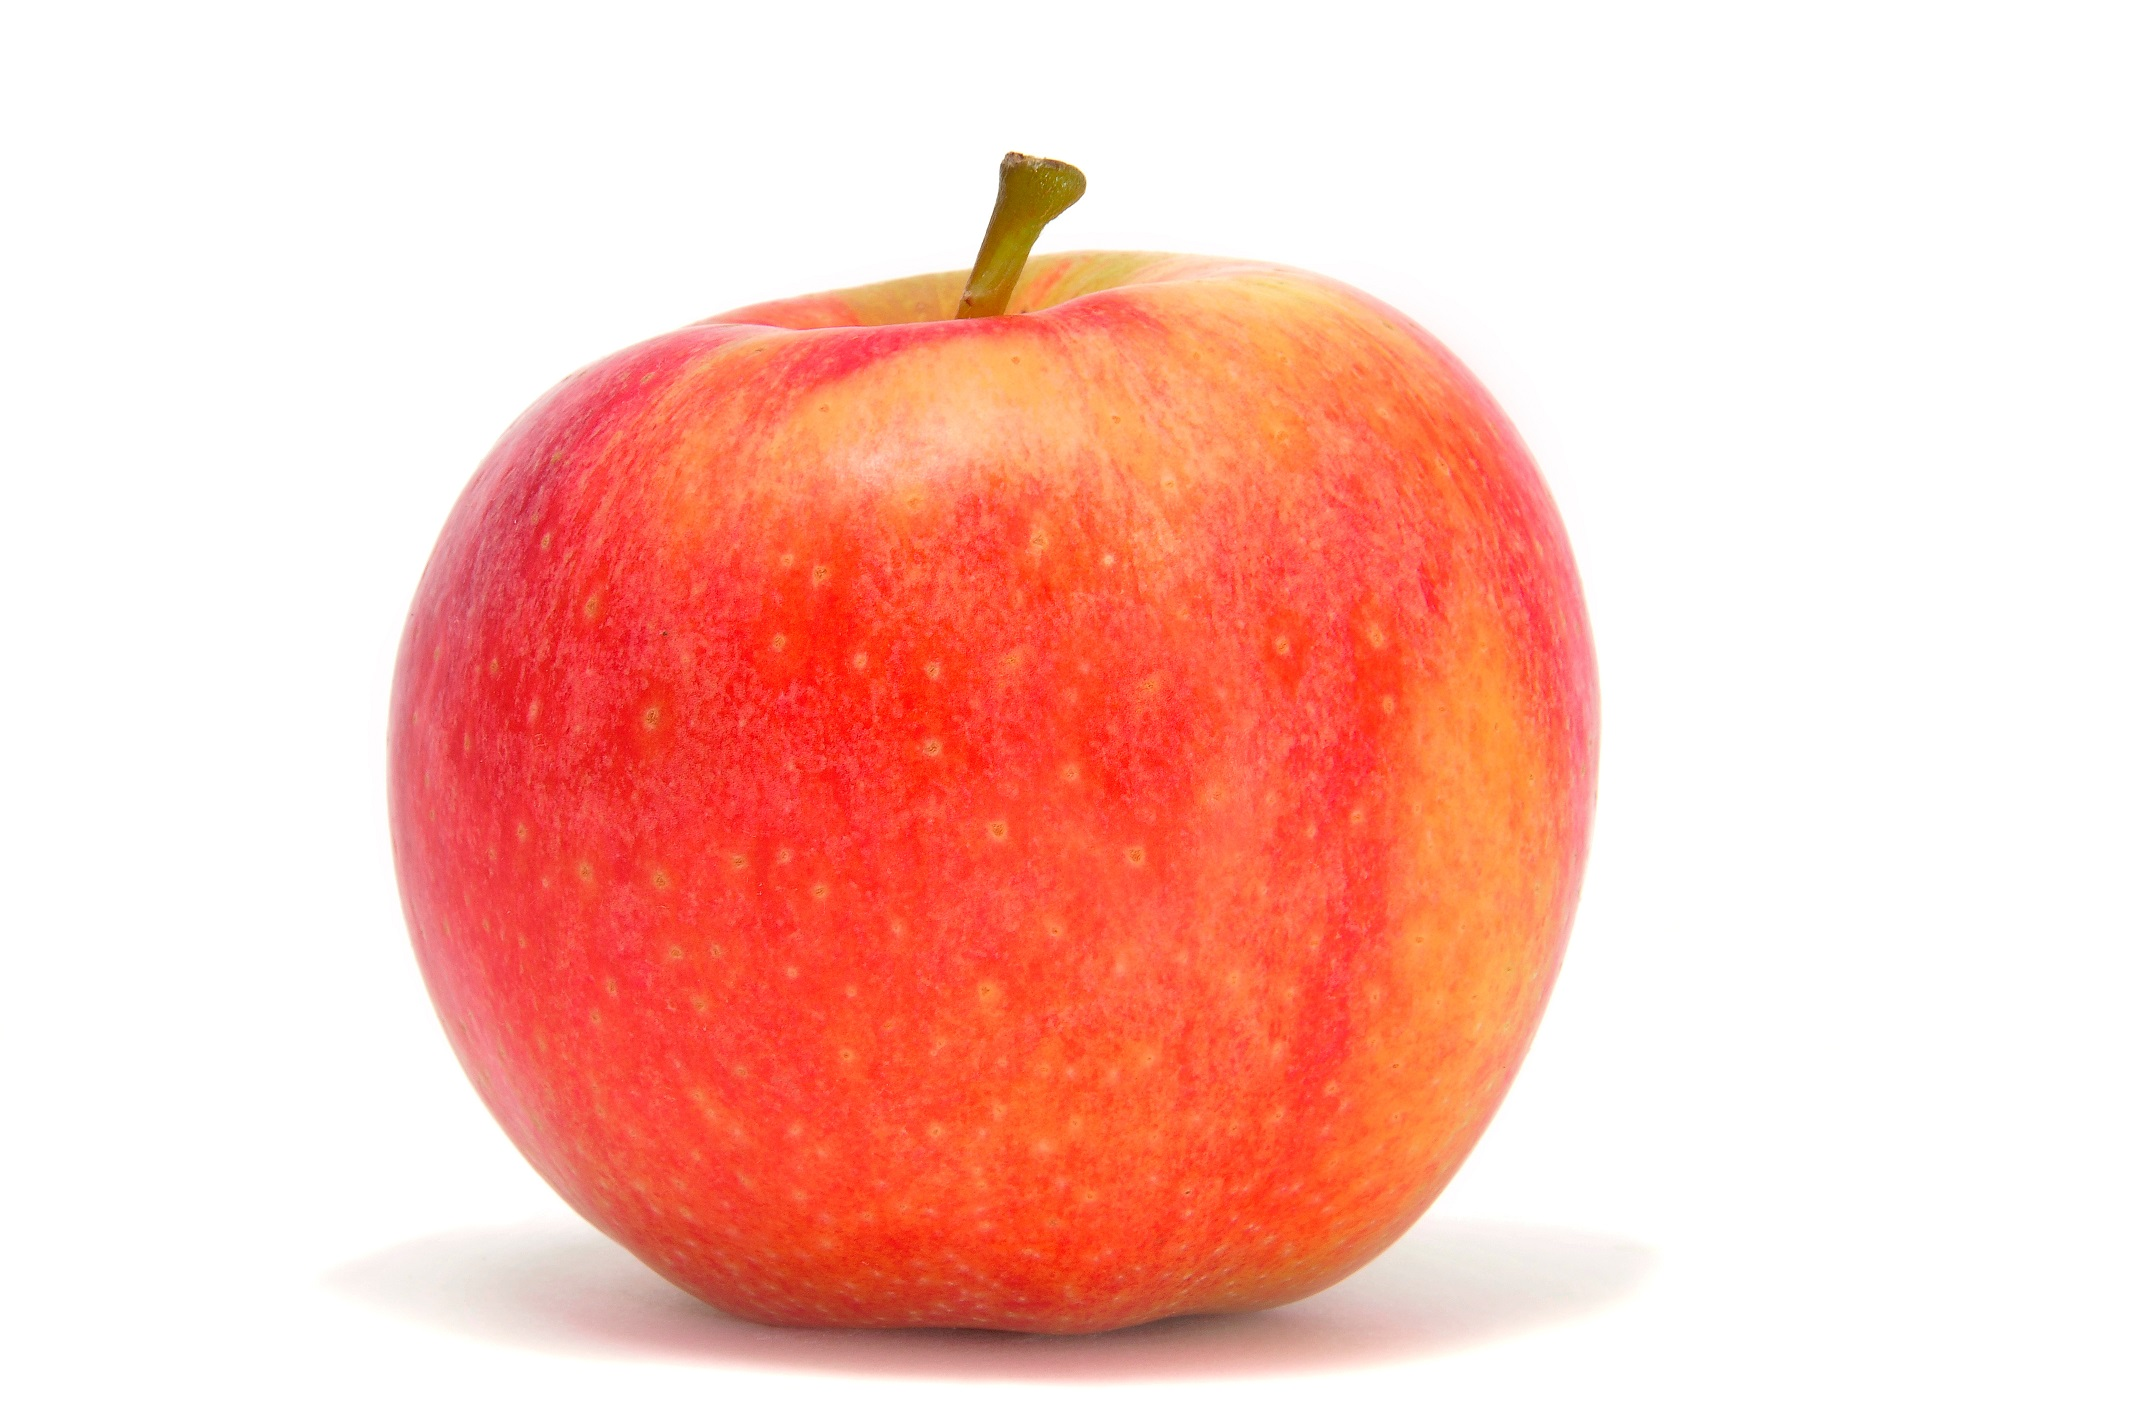

In [21]:
display(Image(filename=os.path.join(DIR_PATH, keys[0])))

In [22]:
list(sim_sort.keys())[1]

'Jonagold.jpeg'

In [23]:
sim_sort

{'Braeburn.jpeg': 0.9999999999999989,
 'Jonagold.jpeg': 0.9895240581502319,
 'Honeycrisp.jpeg': 0.989381519914118,
 'Rome.jpeg': 0.9854293034815633,
 'PinkLady.jpeg': 0.9815199769745505,
 'Fiji.jpeg': 0.9795921566101947,
 'RedDelicious.jpeg': 0.973335036887303,
 'GrannySmith.jpeg': 0.9640735139033183,
 'GoldenDelicious.jpeg': 0.9570541881298422,
 'two_apples.jpeg': 0.934844974145287,
 'PIC02.jpeg': 0.7032198577934606,
 'PIC05.jpeg': 0.6925315035119061,
 'PIC06.jpeg': 0.6914508424125311,
 'PIC03.jpeg': 0.6903622396976467,
 'PIC01.jpeg': 0.6551978428852427,
 'PIC04.jpeg': 0.6292606985959165}

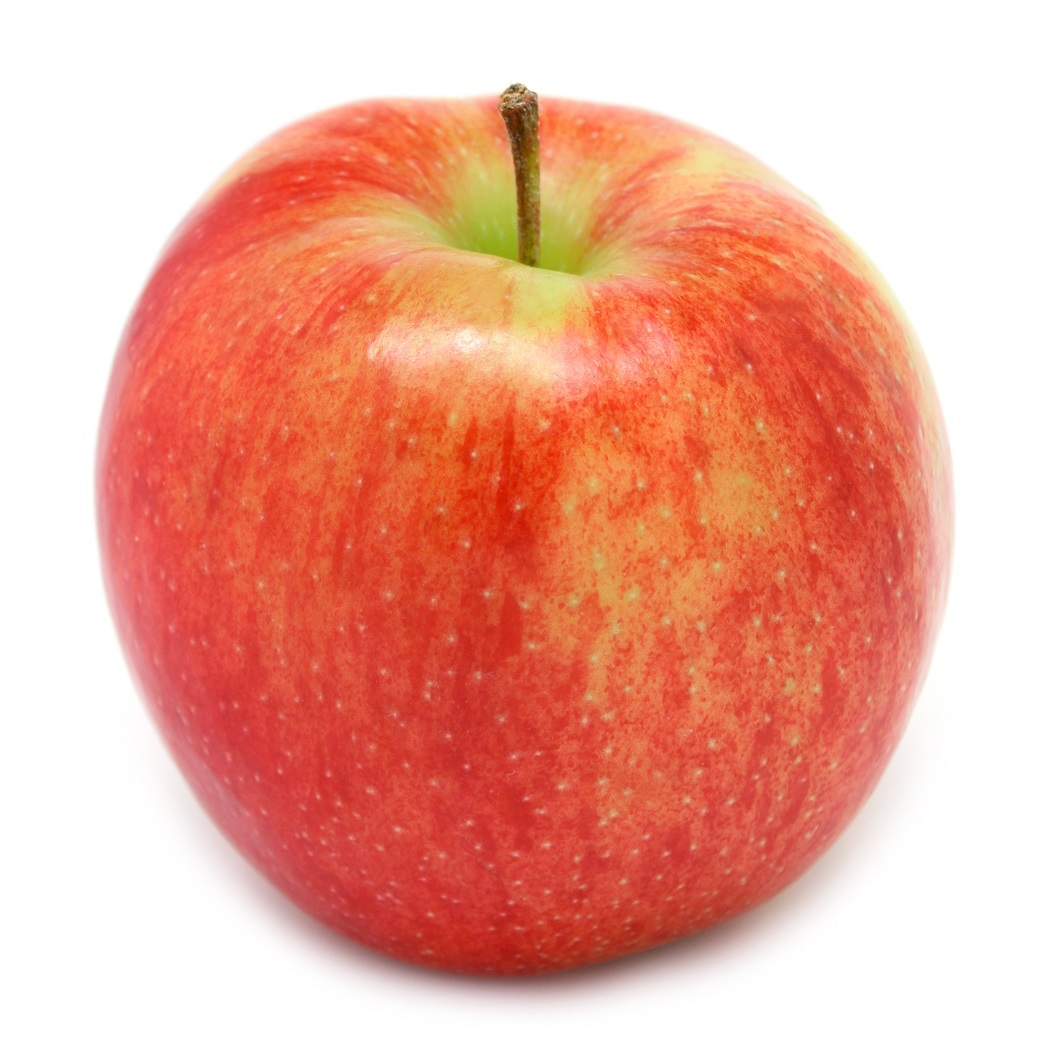

In [24]:
display(Image(filename=os.path.join(DIR_PATH, list(sim_sort.keys())[1])))

In [25]:
def generate_embeddings(text, aiVisionEndpoint, aiVisionApiKey):  
    url = f"{aiVisionEndpoint}/computervision/retrieval:vectorizeText"  
  
    params = {  
        "api-version": "2023-02-01-preview"  
    }  
  
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": aiVisionApiKey  
    }  
  
    data = {  
        "text": text  
    }  
  
    response = requests.post(url, params=params, headers=headers, json=data)  
  
    if response.status_code == 200:  
        embeddings = response.json()["vector"]  
        return embeddings  
    else:  
        print(f"Error: {response.status_code} - {response.text}")  
        return None  

In [26]:
text = "winter clothes"

In [27]:
vector_text = generate_embeddings(text, aiVisionEndpoint, aiVisionApiKey)

In [28]:
vector_text[:4]

[-0.006373207, -0.009834954, -0.002471979, 0.009644186]

In [29]:
len(vector_text)

1024

In [30]:
arr1 = [vector_text]

In [31]:
for file in FILES:
    sim = cosine_similarity(arr1, [image_embeddings[file]])
    sim_dict[file] = sim[0][0]

In [32]:
len(image_embeddings[file])

1024

In [33]:
sim_dict

{'Braeburn.jpeg': -0.008911420910634476,
 'Fiji.jpeg': -0.01301387599695162,
 'GoldenDelicious.jpeg': -0.02060605538490707,
 'GrannySmith.jpeg': -0.017465515949165237,
 'Honeycrisp.jpeg': -0.01292716519097622,
 'Jonagold.jpeg': -0.010508549638280365,
 'PIC01.jpeg': -0.02017511342333633,
 'PIC02.jpeg': -0.013709358227835354,
 'PIC03.jpeg': -0.021913716769906662,
 'PIC04.jpeg': 0.013809621633332703,
 'PIC05.jpeg': -0.003739648962823968,
 'PIC06.jpeg': -0.0011395593362448306,
 'PinkLady.jpeg': -0.01704905265271312,
 'RedDelicious.jpeg': -0.014369874423006242,
 'Rome.jpeg': -0.01568820346415941,
 'two_apples.jpeg': -0.01834693905702548}

In [34]:
sim_sort = dict(sorted(sim_dict.items(), key=lambda item: item[1],reverse=True))

In [35]:
sim_sort

{'PIC04.jpeg': 0.013809621633332703,
 'PIC06.jpeg': -0.0011395593362448306,
 'PIC05.jpeg': -0.003739648962823968,
 'Braeburn.jpeg': -0.008911420910634476,
 'Jonagold.jpeg': -0.010508549638280365,
 'Honeycrisp.jpeg': -0.01292716519097622,
 'Fiji.jpeg': -0.01301387599695162,
 'PIC02.jpeg': -0.013709358227835354,
 'RedDelicious.jpeg': -0.014369874423006242,
 'Rome.jpeg': -0.01568820346415941,
 'PinkLady.jpeg': -0.01704905265271312,
 'GrannySmith.jpeg': -0.017465515949165237,
 'two_apples.jpeg': -0.01834693905702548,
 'PIC01.jpeg': -0.02017511342333633,
 'GoldenDelicious.jpeg': -0.02060605538490707,
 'PIC03.jpeg': -0.021913716769906662}

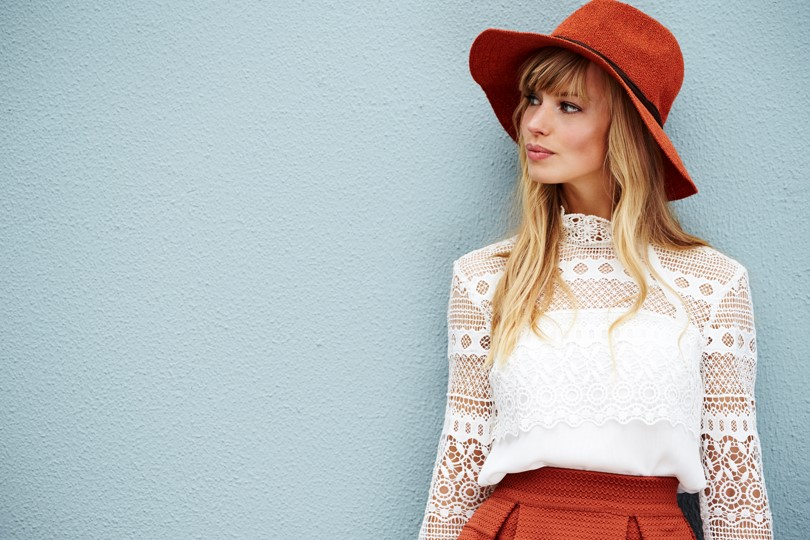

In [36]:
display(Image(filename=os.path.join(DIR_PATH, list(sim_sort.keys())[0])))

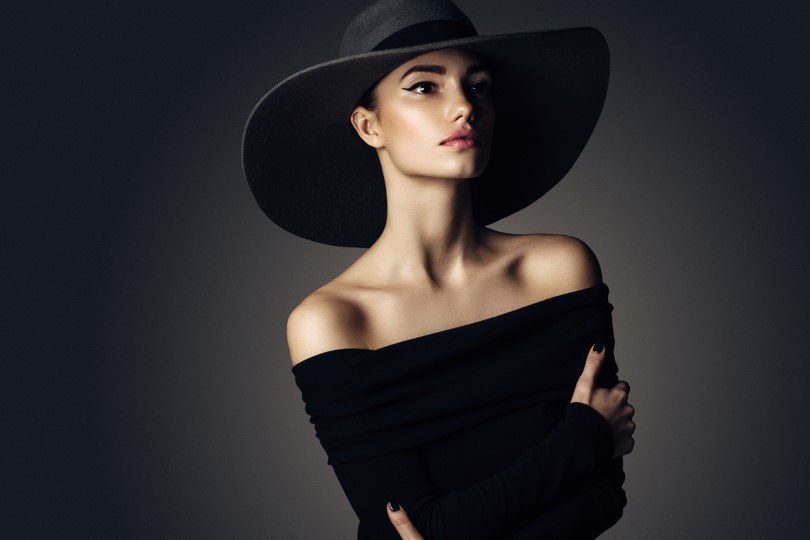

In [37]:
display(Image(filename=os.path.join(DIR_PATH, list(sim_sort.keys())[1])))

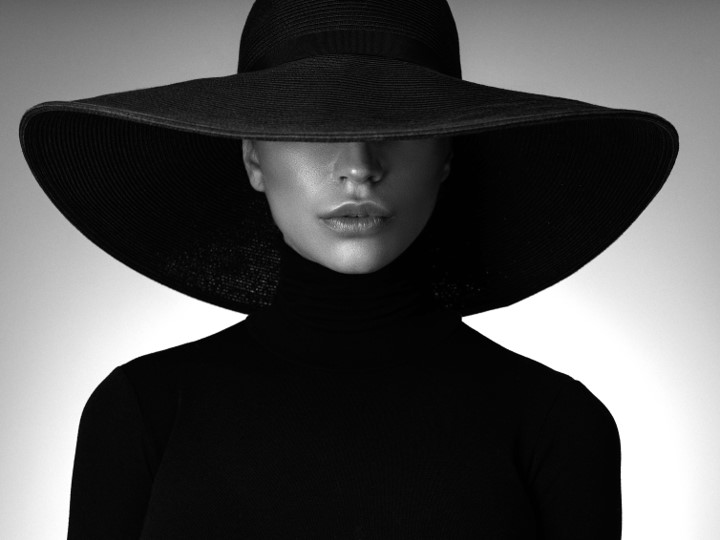

In [38]:
display(Image(filename=os.path.join(DIR_PATH, list(sim_sort.keys())[2])))

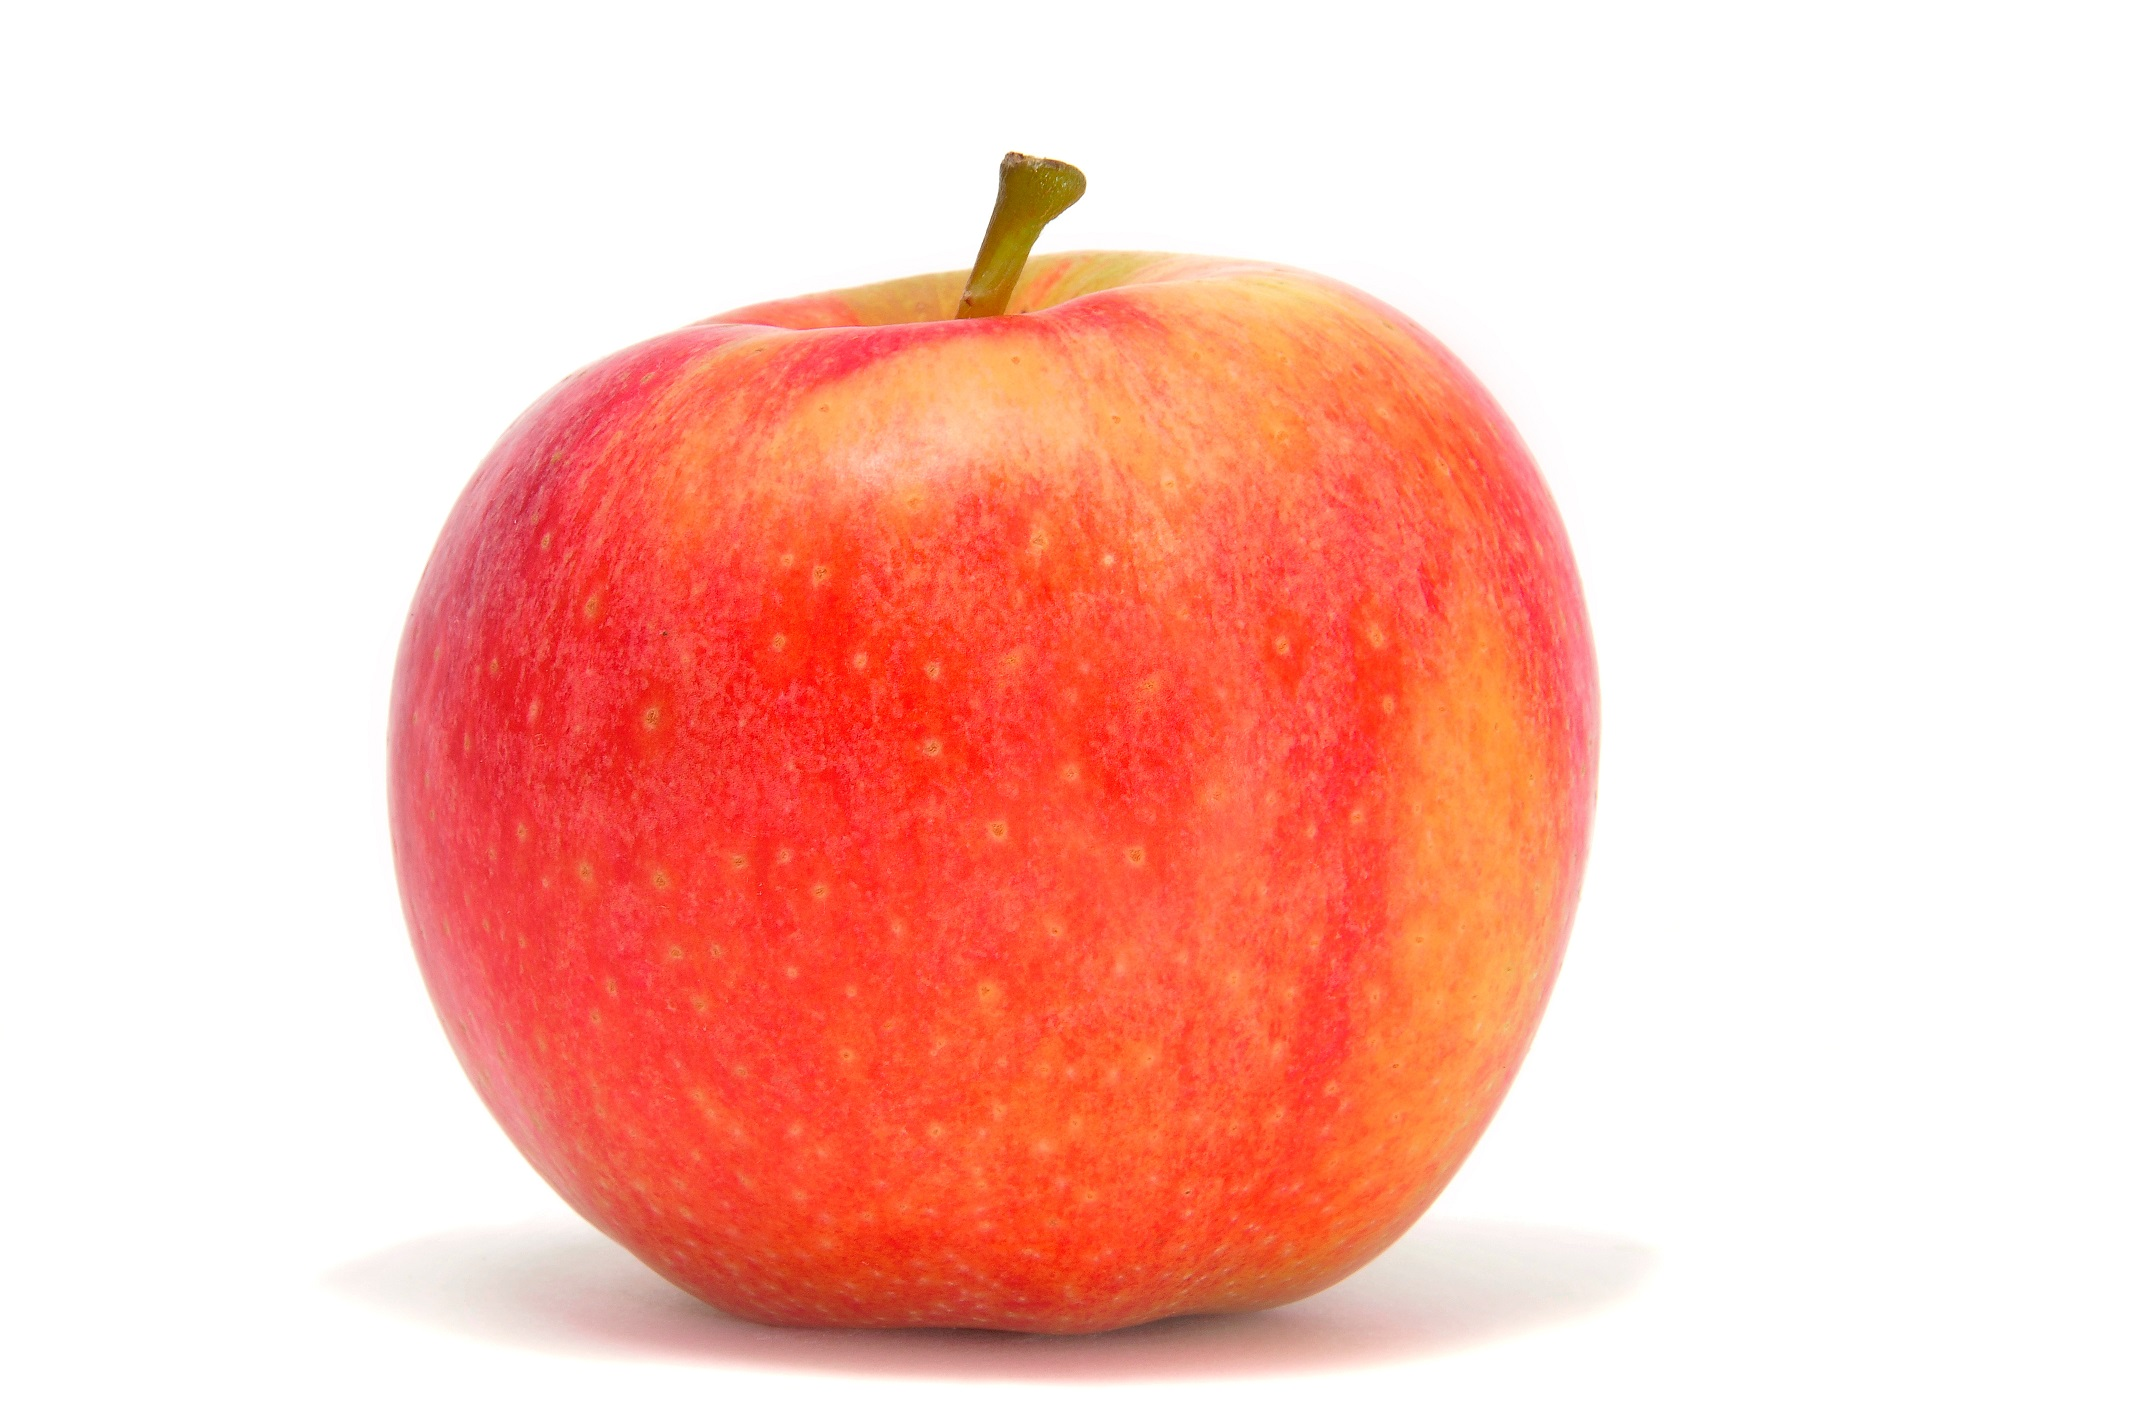

In [39]:
display(Image(filename=os.path.join(DIR_PATH, list(sim_sort.keys())[3])))